In [1]:
# R version 4.1.0 #
# Load packages: Seurat_4.1.1, RColorBrewer_1.1-3, ggplot2_3.3.6, extrafont_0.18, dplyr_1.0.9, tidyr_1.2.0
# purrr_0.3.4, stringr_1.4.0, zoo_1.8-10

packages = c('Seurat','RColorBrewer','ggplot2','extrafont','dplyr','tidyr','purrr','stringr','zoo')
for (p in packages){
    suppressPackageStartupMessages(eval(bquote(library(.(p)))))
}

bnum_table <- read.delim('source_data/included/ecoli_bnum_table_updated_2.txt',sep='\t')

get_gene_list <- function(name,seurat){
    bnums <- c()
    genes <- c()
    for (annotation_type in c('go','tf','sr')){
        data_name = str_replace("source_data/included/Ecoli_RENAME_index.txt","RENAME",annotation_type)
        data = readLines(data_name)
        for (line in data[grepl(name, data)]){
            bnum <- strsplit(line,'\t')[[1]][1]
            if (bnum %in% bnum_table[['bnum']]){
                gene <- bnum_table[bnum_table['bnum']==bnum,'gene']
                if (gene %in% rownames(seurat)){
                    bnums <- c(bnums,bnum)
                    genes <- c(genes,gene)
                }
            }
        }
    }
    return(genes)
}


In [2]:
plot_pc1 <- function(sub_seurat,cols,slot=sub_seurat$seurat_clusters,xmin,xmax) {
    umap_df <- data.frame(umap = sub_seurat$pca@cell.embeddings[,'PC_1'],type=slot)
    umap_df2 <- umap_df %>%
      nest(-type) %>%
      mutate(density = map(data, ~density(.x$umap))) %>%
      mutate(density.x = map(density, ~.x[["x"]]),
             density.y = map(density, ~.x[["y"]])) %>%
      select(type, density.x, density.y) %>%
      unnest()
    options(repr.plot.width=4.2358, repr.plot.height=1.2)
    p <- ggplot(umap_df2,aes(x = density.x, y = density.y, color = type)) + geom_line(size=1)+theme_classic()+
    scale_color_manual(labels = levels(slot),values = cols,name='') + 
    scale_fill_manual(labels = levels(slot),values = alpha(cols,1),name='') +
    xlim(xmin,xmax) +
    theme(text=element_text(family= "Arial", size=12)) + 
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.text.y=element_blank(),  #remove y axis labels
        axis.ticks.y=element_blank(),  #remove y axis ticks
        legend.position = "none",
        axis.title.x=element_blank(),
        axis.title.y=element_blank()) 
    return(p)
}

Warning message:
“Supplying `...` without names was deprecated in tidyr 1.0.0.
ℹ Please specify a name for each selection.
ℹ Did you want `data = -type`?”
Warning message:
“`cols` is now required when using `unnest()`.
ℹ Please use `cols = c(density.x, density.y)`.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 75 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 75 rows containing missing values or values outside the scale range (`geom_line()`).”


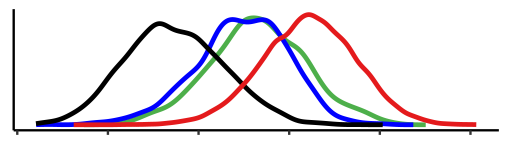

In [3]:
seurat <- readRDS('source_data/generated/fig3_persister_only.rds') # saved in fig3_persister_only.R
seurat@active.ident <- seurat$cell.group
ids = c('metG','WT_d6','hipA7','tet')
seurat <- subset(seurat,idents=ids)
seurat$cell.group <- droplevels(seurat$cell.group)

xmin = min(seurat$pca@cell.embeddings[,'PC_1'])
xmax = max(seurat$pca@cell.embeddings[,'PC_1'])

my_cols = brewer.pal(8,"Set1")
colors = c(my_cols[3],'blue','black',my_cols[1])
plot_pc1(seurat,colors,slot=seurat$cell.group,xmin,xmax) 
ggsave('figures/figED9b_top.pdf',width = 4.2358,height = 1.2) # colors changed in illustrator


Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”


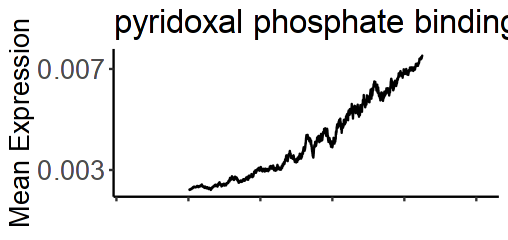

Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”


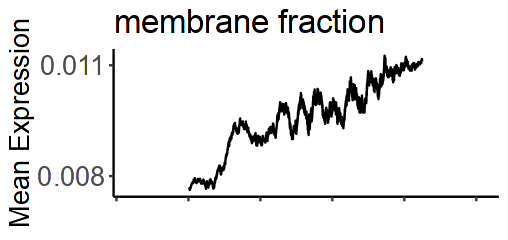

Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”


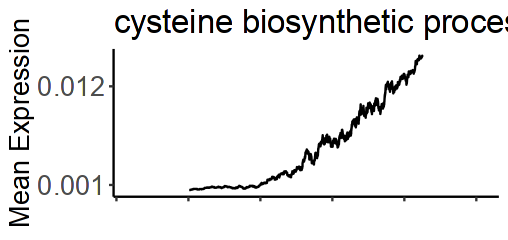

Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”


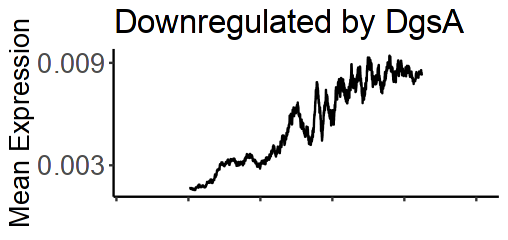

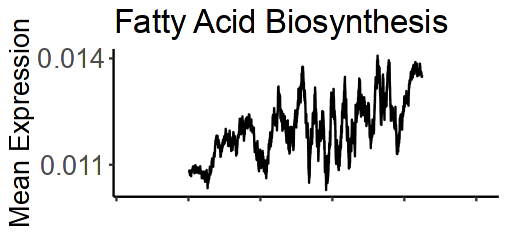

In [4]:
selected_terms <- c('GO:0030170','GO:0005624','GO:0019344','DgsA_Down','GO:0006633') ## from figure3_py notebook
names <- c('pyridoxal phosphate binding','membrane fraction','cysteine biosynthetic process','Downregulated by DgsA','Fatty Acid Biosynthesis')
options(repr.plot.width=4.2358, repr.plot.height=2)
seurat@active.ident <- seurat$cell.group
xmin = min(seurat$pca@cell.embeddings[,'PC_1'])
xmax = max(seurat$pca@cell.embeddings[,'PC_1'])
ymins = c(0.003,0.008,0.001,0.003,0.011)
ymaxs = c(0.007,0.011,0.012,0.009,0.014)

for (i in 1:length(selected_terms)){
    my_cols = brewer.pal(10,"Spectral")
    marker_list <- get_gene_list(str_split(selected_terms[i],' ',simplify=TRUE)[1],seurat) ## all bnums in term
    marker_list <- unique(marker_list)
    seurat$new.feat <- colMeans(seurat$RNA@data[marker_list,])
    l = seurat$new.feat[order(seurat$pca@cell.embeddings[,'PC_1'])]
    pc = seurat$pca@cell.embeddings[,'PC_1'][order(seurat$pca@cell.embeddings[,'PC_1'])]
    k = 1000
    df <- data.frame(l)
    df$pc <- pc
    df <- df %>%
        mutate(avg_exp = rollmean(l, k=k, fill=NA, align='right')) %>%
        mutate(avg_pc = rollmean(pc, k=k, fill=NA, align='right'))
    p <- ggplot(df, aes(x=avg_pc, y=avg_exp)) + geom_line() + theme_classic() + ggtitle(names[i])
    p <- p + theme(text=element_text(family= "Arial", size=16),axis.text=element_text(family='Arial',size=16),axis.text.x=element_blank(),legend.position='none')
    p <- p + xlab('') + ylab('Mean Expression') + xlim(xmin,xmax) + scale_y_continuous(breaks=c(ymins[i],ymaxs[i]))
    p <- p + theme(text=element_text(family= "Arial", size=16),axis.text=element_text(family='Arial',size=16))
    print(p)
    filename = paste('figures/figED9b_',str_replace(str_split(selected_terms[i],' ',simplify=TRUE)[1],':','_'),'.pdf',sep='')
    ggsave(filename,width = 5.06,height = 1.5)
}

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
First group.by variable `ident` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.


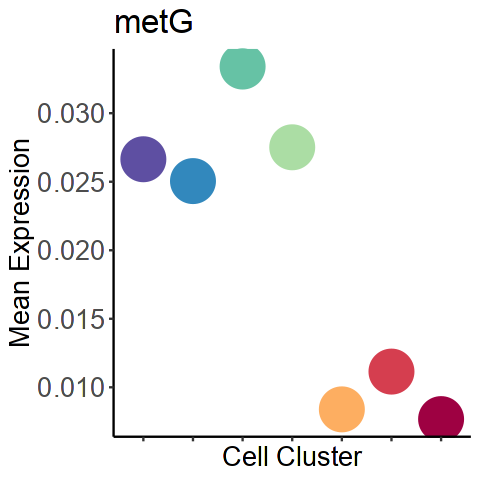

In [5]:
seurat <- readRDS('source_data/from_GEO/ds_seurat_PCA_UMAP_clusters_ds38_min10_v4.rds') # saved from GEO
# subset seurat object to only metG* persister cells (atlas as introduced in figure 1)
to_include = c('t1_2hr_WT_20210722','t1_20min_WT_20210722','t1_undil_WT_20210722',
               't2_20min_WT_20210722','t2_undil_WT_20210722','t3_undil_WT_20210722',
               't4_2hr_WT_20210722','t4_1hr_WT_20210722','t4_20min_WT_20210722','t4_undil_WT_20210722',
               't1_2hr_metG_20210623','t1_20min_metG_20210623','t1_undil_metG_20210623',
               't2_2hr_metG_20210623','t2_20min_metG_20210623','t2_undil_metG_20210623','t3_undil_metG_20210623',
               't4_2hr_metG_20210623','t4_20min_metG_20210623','t4_undil_metG_20210623',
               'WT_1hr_20220331','WT_30min_20220331','WT_10min_20220331','WT_3min_20220331','WT_stat_20220331',
               'metG6_20201018_1','metG5_20201018_1','metG4_20201018_1','metG3_20201018_1','metG2_20200926','metG1_20200926','WT_10min_20220210')
seurat@active.ident <- seurat$cell.type
seurat <- subset(seurat,idents=to_include)
seurat@active.ident <- seurat$cell.type
seurat <- subset(seurat,idents=to_include)

options(repr.plot.width=4, repr.plot.height=4)
seurat@active.ident <- seurat$seurat_clusters
my_cols = brewer.pal(10,"Spectral")

term_avg <- colMeans(AverageExpression(seurat,slot='data',features='metG')$RNA)
df <- data.frame(rev(term_avg))
df['cluster'] = rev(c('0','1','2','3','4','5','6'))
df['border'] = rev(c('0','1','2','3','4','5','6'))
fill_colors = rev(my_cols[c(1,2,4,7,8,9,10)])
labels = rev(c("Early Stationary","Stationary","Persister","Early Lag","Late Lag","Early Exponential","Late Exponential"))
border_colors = fill_colors
p <- ggplot(data=df, aes(x=cluster, y=term_avg,group=1,fill=border,color=border)) +
    geom_point(size=8,shape=21,stroke=3) + theme_classic() + scale_fill_manual(values=fill_colors,name='',labels=labels) + 
    scale_color_manual(values=border_colors,name='',labels=labels) + 
    theme(text=element_text(family= "Arial", size=16),legend.position='none',
        axis.text.y = element_text(family= "Arial", size=16),
        axis.text.x = element_blank()) + 
    xlab('Cell Cluster') + ylab('Mean Expression') + ggtitle('metG')
print(p)
ggsave('figures/figED9c_top.pdf',width = 4,height = 4)


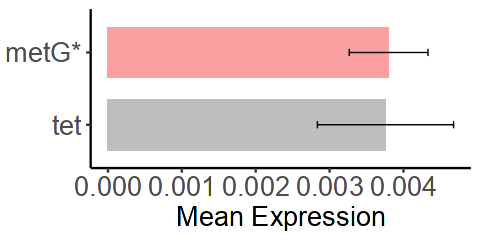

In [6]:
seurat_clust2 <- readRDS('source_data/generated/fig3_persister_only.rds') # saved in fig3_persister_only.R
seurat <- readRDS('source_data/from_GEO/ds_seurat_PCA_UMAP_clusters_ds38_min10_v4.rds') # saved from GEO

options(repr.plot.width=4, repr.plot.height=2)
seurat_clust2@active.ident <- seurat_clust2$cell.group
slot = 'data'
for (gene in c('metG')){
    my_cols = brewer.pal(10,"Spectral")
    cells <- names(subset(seurat_clust2,idents=c('tet'))$cell.type)
    gene_list = subset(seurat,cells=cells)$RNA@data[gene,]
    mean_tet <- mean(exp(gene_list)-1)
    se_tet <- sd(exp(gene_list)-1)/sqrt(length(gene_list))
    cells <- names(subset(seurat_clust2,idents=c('metG'))$cell.type)
    gene_list = subset(seurat,cells=cells)$RNA@data[gene,]
    mean_metG <- mean(exp(gene_list)-1)
    se_metG <- sd(exp(gene_list)-1)/sqrt(length(gene_list))
    df <- data.frame(exp=c(mean_metG,mean_tet),names=c('metG*','tet'),se=c(se_metG,se_tet))
    df$names = factor(df$names,levels=c('tet','metG*'))
    p<-ggplot(data=df, aes(x=names, y=exp, fill=names)) +
        geom_bar(stat="identity",width=0.7) + theme_classic() + 
        geom_errorbar(aes(ymin=exp-se, ymax=exp+se), width=.1,size=0.3) + 
        scale_fill_manual(values=c('grey','#FAA0A0')) + 
        theme(text=element_text(family= "Arial", size=16),legend.position='none',
            axis.text.y = element_text(family= "Arial", size=16),
            axis.text.x = element_text(family= "Arial", size=16),
            axis.title.y = element_blank(),
            axis.title.x = element_text(family= "Arial", size=16),
            plot.title=element_text(size=16)) + 
        ylab('Mean Expression')
    p <- p + coord_flip()
    print(p)
    ggsave('figures/figED9c_bottom.pdf',width=4,height=2)
}

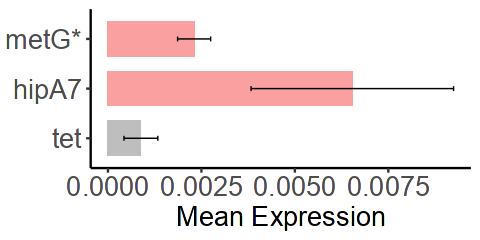

In [7]:
options(repr.plot.width=4, repr.plot.height=2)
seurat_clust2@active.ident <- seurat_clust2$cell.group
slot = 'data'

for (gene in c('hipA')){
    my_cols = brewer.pal(10,"Spectral")
    term_avg <- colMeans(AverageExpression(seurat,slot='data',features=gene)$RNA)
    mean_all = mean(term_avg)
    cells <- names(subset(seurat_clust2,idents=c('tet'))$cell.type)
    gene_list = subset(seurat,cells=cells)$RNA@data[gene,]
    mean_tet <- mean(exp(gene_list)-1)
    se_tet <- sd(exp(gene_list)-1)/sqrt(length(gene_list))
    cells <- names(subset(seurat_clust2,idents=c('metG'))$cell.type)
    gene_list = subset(seurat,cells=cells)$RNA@data[gene,]
    mean_metG <- mean(exp(gene_list)-1)
    se_metG <- sd(exp(gene_list)-1)/sqrt(length(gene_list))

    cells <- names(subset(seurat_clust2,idents=c('hipA7'))$cell.type)
    gene_list = subset(seurat,cells=cells)$RNA@data[gene,]
    mean_hip <- mean(exp(gene_list)-1)
    se_hip <- sd(exp(gene_list)-1)/sqrt(length(gene_list))

    df <- data.frame(exp=c(mean_metG,mean_hip,mean_tet),names=c('metG*','hipA7','tet'),se=c(se_metG,se_hip,se_tet))
    df$names = factor(df$names,levels=c('tet','hipA7','metG*'))
    p<-ggplot(data=df, aes(x=names, y=exp, fill=names)) +
        geom_bar(stat="identity",width=0.7) + theme_classic() + 
        geom_errorbar(aes(ymin=exp-se, ymax=exp+se), width=.1,size=0.3) + 
        scale_fill_manual(values=c('grey','#FAA0A0','#FAA0A0')) + 
        #geom_hline(yintercept=mean_all, size = 0.5) +
        theme(text=element_text(family= "Arial", size=16),legend.position='none',
            axis.text.y = element_text(family= "Arial", size=16),
            axis.text.x = element_text(family= "Arial", size=16),
            axis.title.y = element_blank(),
            axis.title.x = element_text(family= "Arial", size=16),
            plot.title=element_text(size=16)) + 
        ylab('Mean Expression')
    p <- p + coord_flip()
    print(p)
    ggsave(paste('figures/figED9e_',gene,'.pdf',sep=''),width=4,height=2)
}

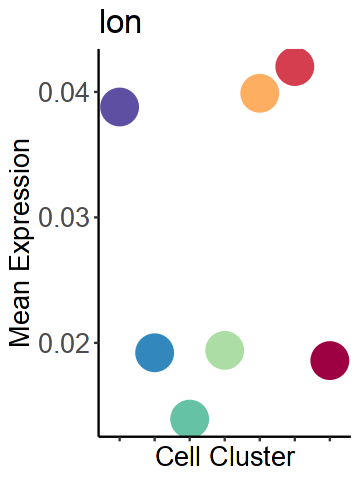

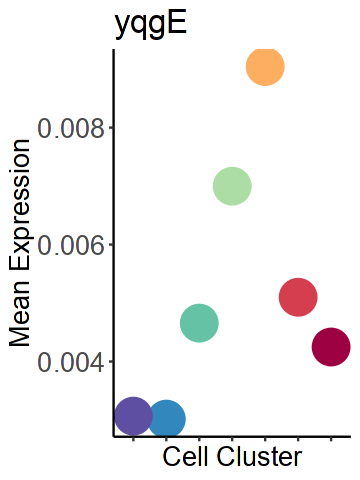

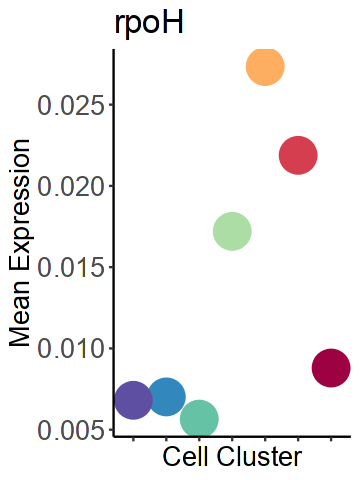

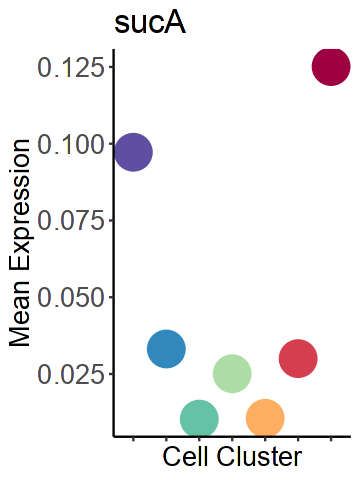

In [8]:
options(repr.plot.width=3, repr.plot.height=4)
seurat@active.ident <- seurat$seurat_clusters
my_cols = brewer.pal(10,"Spectral")

genes <- c('lon','yqgE','rpoH','sucA')
for (gene in genes){
    term_avg <- colMeans(AverageExpression(seurat,slot='data',features=gene)$RNA)
    df <- data.frame(rev(term_avg))
    df['cluster'] = rev(c('0','1','2','3','4','5','6'))
    df['border'] = rev(c('0','1','2','3','4','5','6'))
    fill_colors = rev(my_cols[c(1,2,4,7,8,9,10)])
    labels = rev(c("Early Stationary","Stationary","Persister","Early Lag","Late Lag","Early Exponential","Late Exponential"))
    border_colors = fill_colors
    p <- ggplot(data=df, aes(x=cluster, y=term_avg,group=1,fill=border,color=border)) +
        geom_point(size=6,shape=21,stroke=3) + theme_classic() + scale_fill_manual(values=fill_colors,name='',labels=labels) + 
        scale_color_manual(values=border_colors,name='',labels=labels) + 
        theme(text=element_text(family= "Arial", size=16),legend.position='none',
            axis.text.y = element_text(family= "Arial", size=16),
            axis.text.x = element_blank()) + 
        xlab('Cell Cluster') + ylab('Mean Expression') + ggtitle(gene)
    print(p)
    filename = paste('figures/figED9_',str_replace(str_split(gene,' ',simplify=TRUE)[1],':','_'),'.pdf',sep='')
    ggsave(filename,width = 3, height = 4)
}